In [2]:
import os
import numpy as np
import scipy as sp
from scipy import stats
from scipy import optimize
from functools import partial
from itertools import starmap
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (14,10)
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 8
plt.rcParams["xtick.major.width"] = 1.6
plt.rcParams["xtick.minor.width"] = 0.8
plt.rcParams["xtick.minor.size"] = 4
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.width"] = 1.6
plt.rcParams["ytick.minor.width"] = 0.8
plt.rcParams["ytick.major.size"] = 8
plt.rcParams["ytick.minor.size"] = 4
plt.rcParams["font.size"] = 24
plt.rcParams["lines.linewidth"] = 3
plt.rcParams["lines.markersize"] = 5
plt.rcParams["savefig.dpi"] = 300/2.4
plt.rcParams["savefig.transparent"] = False
plt.rcParams["savefig.facecolor"] = "white"

import multiprocessing
import subprocess

os.makedirs("plots", exist_ok=True)

In [3]:
NUM = 1000

In [4]:
def run_with_args(new_version, nu, lam, randomize=False):
    new = "old"
    if new_version:
        new = "new"
        
    if randomize:
        nu += (np.random.random() - 0.5)/1000
        lam += (np.random.random() - 0.5)/1000
        
    res = subprocess.run(["./test.exe", new, str(float(nu)), str(float(lam))], stdout=subprocess.PIPE)
    try:
        nums = list(map(float, res.stdout.decode("ascii").strip().split("\t")[1:]))
        if not nums:
            raise ValueError("Empty nums")
    except ValueError as e:
        nums = [nu, lam, np.nan, np.nan]
    return pd.DataFrame([nums], columns=["ν", "λ", "μsec", "res"])

In [5]:
def many_times(f, num):
    res = []
    for i in range(num):
        res.append(f())
    return pd.concat(res)

In [6]:
def compare_with_args(nu, lam, num):
    old = many_times(partial(run_with_args, False, nu, lam, True), num)
    new = many_times(partial(run_with_args, True, nu, lam, True), num)
    res = old.rename(columns={"μsec": "μsec_old", "res": "res_old"})
    res["μsec_new"] = new["μsec"]
    res["res_new"] = new["res"]
    return res

In [7]:
def descriptive(compare_df):
    nu, lam = compare_df["ν"].mean(), compare_df["λ"].mean()
    old_mean, new_mean = compare_df["μsec_old"].median(), compare_df["μsec_new"].median()
    old_err, new_err = np.quantile(np.absolute(compare_df["μsec_old"] - old_mean), 0.95), np.quantile(np.absolute(compare_df["μsec_new"] - new_mean), 0.95)
    
    old_mean_res, new_mean_res = compare_df["res_old"].median(), compare_df["res_new"].median()
    old_err_res, new_err_res = np.quantile(np.absolute(compare_df["res_old"] - old_mean_res), 0.95), np.quantile(np.absolute(compare_df["res_new"] - new_mean_res), 0.95)
    
    if np.absolute(compare_df["res_old"].mean() - compare_df["res_new"].mean()) > 0.01:
        raise Exception(f"wrong answer: {nu}, {lam}. old: {compare_df['res_old'].mean()}, new: {compare_df['res_new'].mean()}")
    return pd.DataFrame([[nu, lam, old_mean, old_err, new_mean, new_err, old_mean_res, old_err_res, new_mean_res, new_err_res]],
                        columns=["ν", "λ", "μsec_old", "μsec_old_err", "μsec_new", "μsec_new_err", "res_old", "res_old_err", "res_new", "res_new_err"])

In [8]:
descriptive(compare_with_args(10, 500, 100))

,ν,λ,μsec_old,μsec_old_err,μsec_new,μsec_new_err,res_old,res_old_err,res_new,res_new_err
0,10.000026,500.0,39.0,8.0,31.0,3.05,507.007,0.001,507.007,0.001


## Setting the scale threshold

Defining boundaries for the search region is required for finding the maximum of the PDF in Boost. For this initial point (`guess` or $x_0$) is provided, then algorithm itertively searches upwards and downwards from the `guess` for the point where the value of the PDF is smaller than in the `guess`. It would mean that somewhere inbetween there is a local maximum. Search upwards is conducted by checking points: $2 \cdot x_0$, $4 \cdot x_0$, $8 \cdot x_0$, ... until the value is smaller than in the $x_0$. For the downwards search points $x_0 / 2^n$ are checked sequentially. Thus it is essential to make a precise guess from the beginning in order to save iterations.

At the moment of writing this, Boost library used $x_0 = k + 1$ as initial guess.  In the regime where our approximation is applicable ($\frac{k}{\lambda} << 1$) we can try estimating when does $k + 1$ starts undershooting. We find the limiting condition when first step upwards is not enough to cover approximate maximum:

$$
\begin{align}
    k + \lambda - 3 &> 2 \cdot (k + 1) \\
    \lambda &> k + 5
\end{align}
$$

Now, for any number of d.o.f $k$ we can find the scale $\frac{k}{\lambda} = \frac{1}{\alpha}$ below which we start undershooting (meaning, $\alpha$ that defines $\lambda = \alpha k$ above which we start undershooting)

$$
\begin{align}
    \lambda &> k + 5 \\
    \alpha k &> k + 5 \\
    \alpha &> \frac{5}{k} + 1
\end{align}
$$

Now, taking into account that the maximum exists starting from $k = 2$. We can put a lower limit on $\alpha$ by assuming that $k = 2$:

$$
    \alpha > \frac{5}{2} + 1 = 3.5
$$

or, in terms of $\frac{k}{\lambda}$:

$$
    \frac{k}{\lambda} < 1/3.5 \approx 0.25
$$

It turns out that the threshold is smaller than $1$, so we can expect that in the region where our approximation improves Boost's performance it is also (potentially) applicable. We will check the performance improvement and applicability of the approximation with plots below.

In [9]:
SWITCH_THRESHOLD = 0.25

#### Runtime improvement

In this set of tests we pick several values of $\nu$: 2, 12, 50. For each of these values we plot two curves. Blue curve shows runitmes of the Boost original method depending on $\lambda$, while the orange curve show the corrected method. We also mark the place on the $\lambda$ axis where boost's estimation of the initial guess is replaced by our improved guess. Thus we expect two curves to coincide below the dashed line, where fraction $\frac{\nu}{\lambda} > 0.25$.

The y-axis represents runtime in microseconds. Measuring microseconds is at the edge of the OS capabilities, so the number fluctuates due to various technical reasons including CPU caching. To somehow smear these fluctuations we measure runtime 1000 times, then we pick median as a central value and 95% quantile as the errorbar. We also add a very little noise to $\lambda$ and $\nu$ while testing the runtime, this noise makes their values to become imprecise integers.

In [10]:
def table(arglist, num):
    res = [descriptive(compare_with_args(nu, lam, num)) for nu, lam in arglist]
    return pd.concat(res)

In [11]:
def plot_nu_fixed(ax, nu, lams, num):
    args = [[nu, lam] for lam in lams]
    res = table(args, num).sort_values("λ")
    display(res)
    ax.errorbar(res["λ"], res["μsec_old"], yerr=res["μsec_old_err"], label="original")
    ax.errorbar(res["λ"], res["μsec_new"], yerr=res["μsec_new_err"], label="improved")

/home/vindex10/projects/.venvs/sandbox/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/vindex10/projects/.venvs/sandbox/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/vindex10/projects/.venvs/sandbox/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/vindex10/projects/.venvs/sandbox/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


,ν,λ,μsec_old,μsec_old_err,μsec_new,μsec_new_err,res_old,res_old_err,res_new,res_new_err
0,2.000005,4.000010,38.0,8.0,36.0,8.00,2.76533,0.00093,2.76532,0.000961
0,2.000010,8.000000,28.0,7.0,29.0,7.00,6.92148,0.00081,6.92146,0.000800
0,2.000000,15.999992,27.0,7.0,25.0,6.00,14.96540,0.00080,14.96540,0.000800
0,2.000015,31.999999,25.0,7.0,26.0,8.00,30.98360,0.00080,30.98360,0.000800
0,2.000007,63.999993,37.0,6.0,31.0,5.00,62.99200,0.00080,62.99200,0.000800
0,1.999992,128.000000,41.0,5.0,31.0,5.00,126.99600,0.00100,126.99600,0.001000
0,2.000001,256.000000,45.0,6.0,36.0,4.05,254.99800,0.00100,254.99800,0.001000
0,1.999990,512.000000,40.0,5.0,29.0,5.00,510.99900,0.00100,510.99900,0.001000
0,2.000001,1024.000000,54.0,7.0,34.0,4.00,1023.00000,0.00000,1023.00000,0.000000
0,2.000002,2048.000005,NaN,NaN,45.0,6.00,NaN,NaN,2047.00000,0.000000


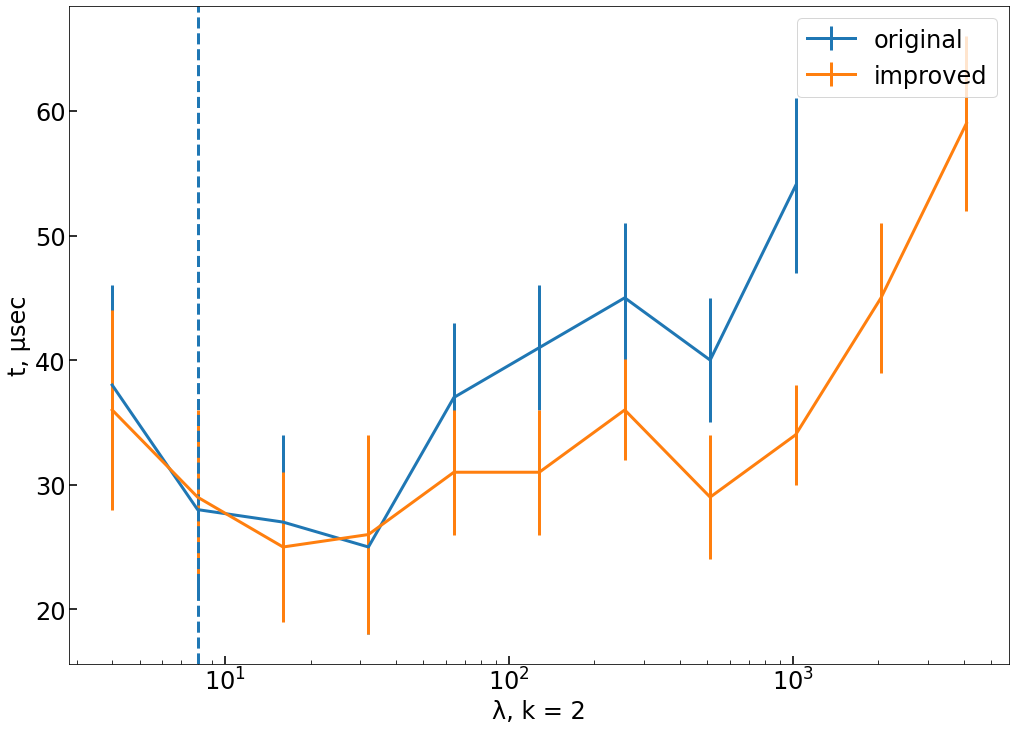

In [24]:
_nu = 2
fig, ax = plt.subplots()
plot_nu_fixed(ax, _nu, [4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096], NUM)
plt.legend()
ax.set_xlabel(f"λ, k = {_nu}");
ax.set_ylabel("t, μsec");
ax.set_xscale("log")
ax.axvline(_nu/SWITCH_THRESHOLD, ls="--", label="switch threshold")
fig.savefig("plots/boost_k_fixed_2.png")

/home/vindex10/projects/.venvs/sandbox/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/vindex10/projects/.venvs/sandbox/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/vindex10/projects/.venvs/sandbox/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/vindex10/projects/.venvs/sandbox/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


,ν,λ,μsec_old,μsec_old_err,μsec_new,μsec_new_err,res_old,res_old_err,res_new,res_new_err
0,15.000003,3.999995,31.0,18.00,36.0,9.05,16.63170,0.00080,16.6317,0.0008
0,15.000010,8.000004,35.0,7.05,34.0,8.00,20.45100,0.00070,20.4510,0.0007
0,14.999998,16.000005,43.0,15.05,38.0,12.00,28.28355,0.00075,28.2836,0.0008
0,14.999993,31.999991,32.0,4.00,30.0,3.00,44.16180,0.00080,44.1618,0.0008
0,14.999996,64.000006,34.0,4.05,30.0,3.00,76.08690,0.00080,76.0869,0.0008
0,15.000001,128.000000,38.0,5.00,34.0,6.00,140.04500,0.00100,140.0450,0.0010
0,14.999993,256.000000,44.0,6.00,38.0,5.00,268.02300,0.00100,268.0230,0.0010
0,15.000021,512.000000,38.0,5.00,29.0,5.00,524.01200,0.00100,524.0120,0.0010
0,15.000003,1024.000000,54.0,11.05,36.0,5.00,1036.01000,0.00000,1036.0100,0.0000
0,15.000008,2048.000007,NaN,NaN,46.0,6.00,NaN,NaN,2060.0000,0.0000


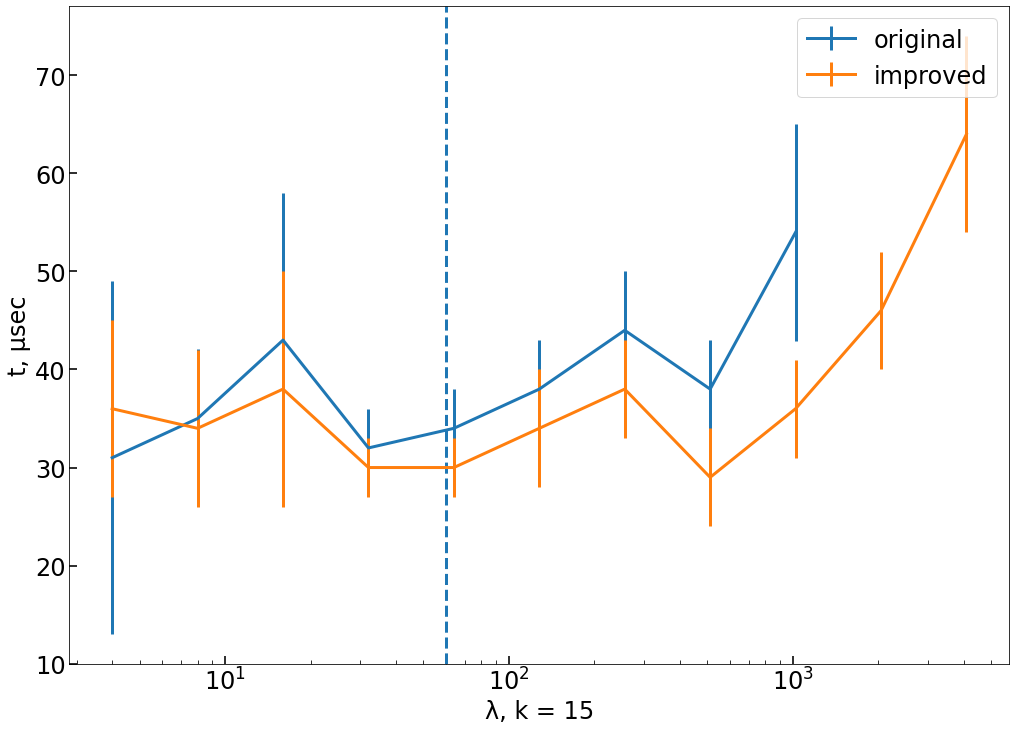

In [25]:
_nu = 15
fig, ax = plt.subplots()
plot_nu_fixed(ax, _nu, [4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096], NUM)
plt.legend()
ax.set_xlabel(f"λ, k = {_nu}");
ax.set_ylabel("t, μsec");
ax.set_xscale("log")
ax.axvline(_nu/SWITCH_THRESHOLD, ls="--", label="switch threshold")
fig.savefig("plots/boost_k_fixed_15.png")

/home/vindex10/projects/.venvs/sandbox/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/vindex10/projects/.venvs/sandbox/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/vindex10/projects/.venvs/sandbox/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/vindex10/projects/.venvs/sandbox/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


,ν,λ,μsec_old,μsec_old_err,μsec_new,μsec_new_err,res_old,res_old_err,res_new,res_new_err
0,49.999988,3.999997,40.0,10.00,39.0,9.05,51.8608,0.0008,51.8608,0.0008
0,49.999995,7.999992,40.0,8.00,43.0,7.00,55.7542,0.0008,55.7542,0.0008
0,50.000009,16.000020,49.0,5.00,48.0,4.00,63.6029,0.0008,63.6029,0.0008
0,50.000008,32.000012,82.0,11.00,78.0,9.00,79.4288,0.0008,79.4288,0.0008
0,49.999996,64.000006,34.0,5.00,35.0,6.00,111.2710,0.0010,111.2710,0.0010
0,49.999998,128.000000,39.0,6.00,39.0,6.00,175.1560,0.0010,175.1560,0.0010
0,50.000006,256.000000,40.0,7.05,34.0,6.00,303.0840,0.0010,303.0840,0.0010
0,49.999989,512.000000,34.0,5.00,32.0,5.00,559.0440,0.0010,559.0440,0.0010
0,50.000015,1024.000000,46.0,7.00,38.0,7.00,1071.0200,0.0000,1071.0200,0.0000
0,49.999998,2048.000008,NaN,NaN,50.0,11.05,NaN,NaN,2095.0100,0.0000


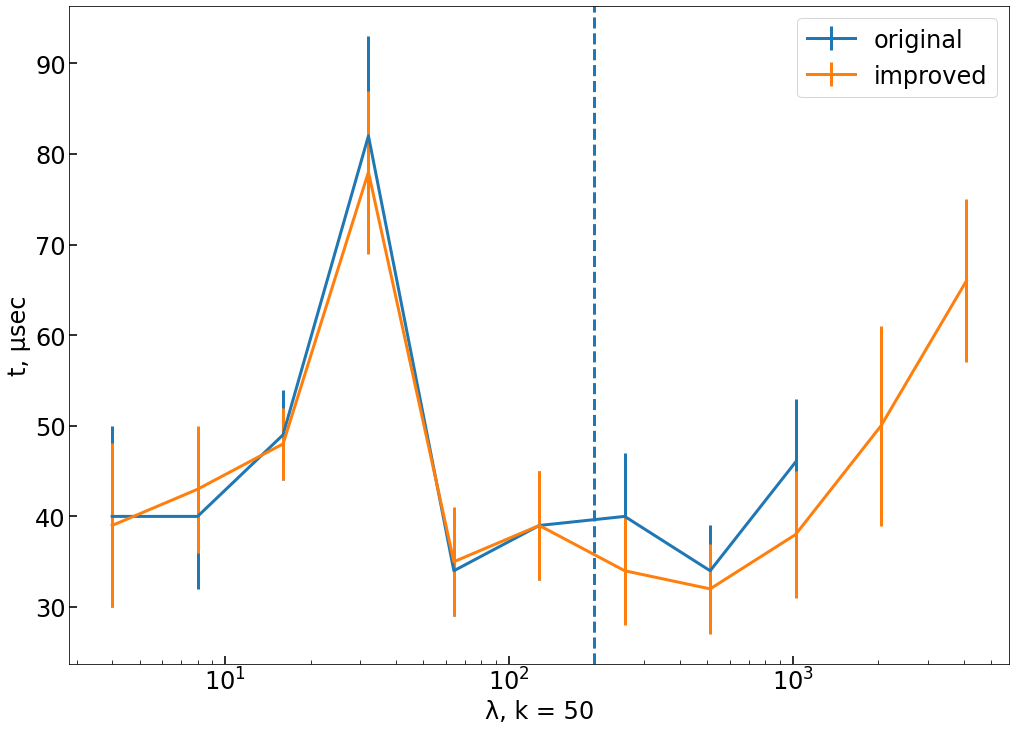

In [31]:
_nu = 50
fig, ax = plt.subplots()
plot_nu_fixed(ax, _nu, [4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096], NUM)
plt.legend()
ax.set_xlabel(f"λ, k = {_nu}");
ax.set_ylabel("t, μsec");
ax.set_xscale("log")
ax.axvline(_nu/SWITCH_THRESHOLD, ls="--", label="switch threshold")
fig.savefig("plots/boost_k_fixed_50.png")

#### Switch threshold test

On the plots below we fix the scale $\frac{\nu}{\lambda}$ to several values: 0.25, 0.15, 0.05. For each scale we plot the dependency of the runtime as a function of $\nu$ (number of d.o.f), while $\lambda$ is inferred from the fixed value of the scale ($\lambda = \frac{\nu}{\mathrm{scale}}$. We plot two curves: blue — representing the boost's runtime, and orange — representing the improved runtime. The smaller is the scale, the better our approximation works, and the larger is the deviation of the boost's initial guess from ours. Thus we expect orange line to be quite close to the blue line at the edge scale (0.25) and deviate to the bottom when the scale is getting smaller.

On the y-axis we show the runtime in microseconds, so we produce numbers in the same way we did in the previous batch of plots including randomization and taking median/percentiles for the presentation.

In [13]:
def threshold_test(ax, scale, nus, num):
    args = [[nu, nu/scale] for nu in nus]
    res = table(args, num).sort_values("λ")
    display(res)
    ax[0].errorbar(res["ν"], res["μsec_old"], yerr=res["μsec_old_err"], label="original")
    ax[0].errorbar(res["ν"], res["μsec_new"], yerr=res["μsec_new_err"], label="improved")
    ax[1].errorbar(res["ν"], res["μsec_old"], yerr=res["μsec_old_err"], label="original")
    ax[1].errorbar(res["ν"], res["μsec_new"], yerr=res["μsec_new_err"], label="improved")

/home/vindex10/projects/.venvs/sandbox/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/vindex10/projects/.venvs/sandbox/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/vindex10/projects/.venvs/sandbox/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/vindex10/projects/.venvs/sandbox/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/vindex10/projects/.venvs/sandbox/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/vindex10/projects/.venvs/sandbox/l

,ν,λ,μsec_old,μsec_old_err,μsec_new,μsec_new_err,res_old,res_old_err,res_new,res_new_err
0,4.000005,16.064257,25.0,5.0,22.0,4.00,17.0964,0.0008,17.0964,0.0008
0,8.000001,32.128523,26.0,5.0,23.0,4.00,37.2028,0.0008,37.2028,0.0008
0,16.000006,64.257018,30.0,4.0,27.0,4.00,77.3501,0.0008,77.3501,0.0008
0,32.000000,128.514061,34.0,6.0,38.0,5.00,157.6160,0.0010,157.6160,0.0010
0,64.000012,257.028105,38.0,2.0,35.0,5.00,318.1350,0.0010,318.1350,0.0010
0,128.000000,514.056207,32.0,7.0,29.0,4.05,639.1650,0.0010,639.1650,0.0010
0,256.000000,1028.110000,36.0,3.0,33.0,3.00,1281.2200,0.0000,1281.2200,0.0000
0,512.000000,2056.223970,45.0,5.0,41.0,4.00,2565.3400,0.0100,2565.3400,0.0100
0,1024.000004,4112.449809,NaN,NaN,57.0,6.00,NaN,NaN,5133.5600,0.0000
0,2047.999992,8224.899596,NaN,NaN,84.0,6.00,NaN,NaN,10270.0000,0.0000


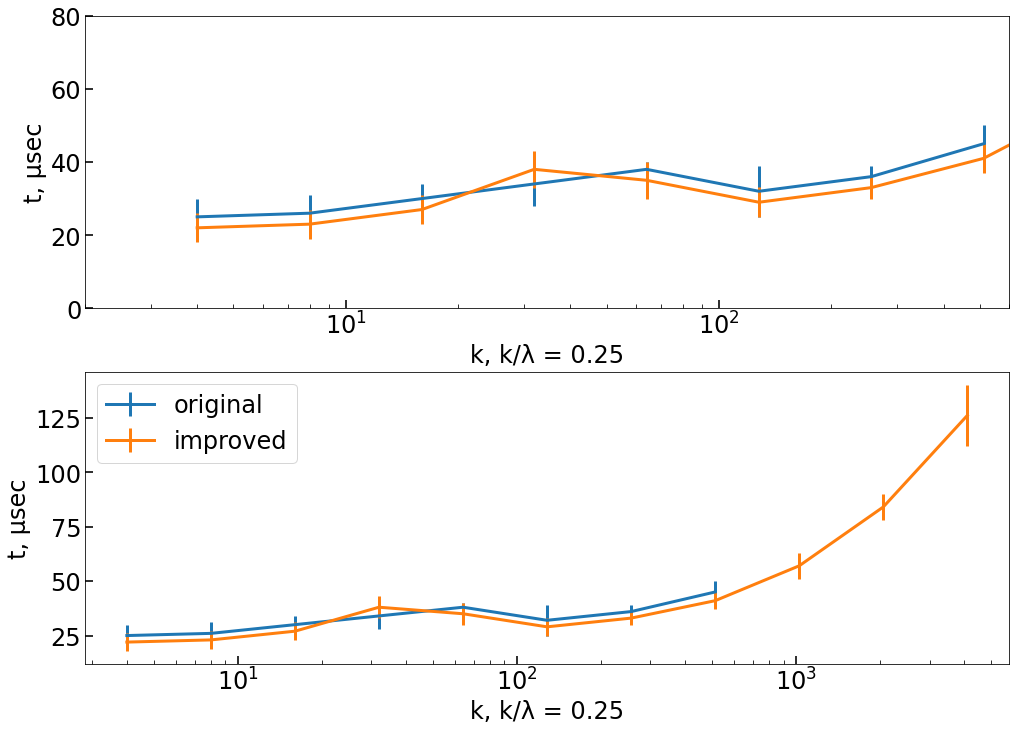

In [14]:
fig, ax = plt.subplots(nrows=2)
_scale = SWITCH_THRESHOLD-0.001
threshold_test(ax, _scale, [4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096], NUM)
plt.legend()
ax[0].set_xlabel(f"k, k/λ = {SWITCH_THRESHOLD}");
ax[0].set_ylabel("t, μsec");
ax[0].set_xscale("log")
ax[0].set_xlim(2, 600)
ax[0].set_ylim(0, 80)
ax[1].set_xlabel(f"k, k/λ = {SWITCH_THRESHOLD}");
ax[1].set_ylabel("t, μsec");
ax[1].set_xscale("log")
fig.savefig("plots/boost_scale_fixed_0_25.png")

/home/vindex10/projects/.venvs/sandbox/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/vindex10/projects/.venvs/sandbox/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/vindex10/projects/.venvs/sandbox/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/vindex10/projects/.venvs/sandbox/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/vindex10/projects/.venvs/sandbox/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/vindex10/projects/.venvs/sandbox/l

,ν,λ,μsec_old,μsec_old_err,μsec_new,μsec_new_err,res_old,res_old_err,res_new,res_new_err
0,3.999995,26.666672,22.0,2.0,20.0,2.0,27.6858,0.0008,27.6858,0.0008
0,7.999994,53.333322,33.0,3.0,28.0,3.0,58.3789,0.0008,58.3789,0.0007
0,15.999987,106.666672,33.0,3.0,29.0,2.0,119.7250,0.0010,119.7250,0.0010
0,31.999992,213.333339,38.0,4.0,34.0,5.0,242.3970,0.0010,242.3970,0.0010
0,63.999990,426.666693,30.0,2.0,32.0,8.0,487.7340,0.0010,487.7340,0.0010
0,128.000000,853.333351,48.0,5.0,38.0,7.0,978.4020,0.0010,978.4020,0.0010
0,256.000000,1706.670000,63.0,6.0,40.0,8.0,1959.7400,0.0000,1959.7400,0.0000
0,511.999995,3413.333342,NaN,NaN,52.0,4.0,NaN,NaN,3922.4000,0.0000
0,1024.000003,6826.666672,NaN,NaN,75.0,7.0,NaN,NaN,7847.7400,0.0000
0,2047.999995,13653.333340,NaN,NaN,110.0,9.0,NaN,NaN,15698.4000,0.0000


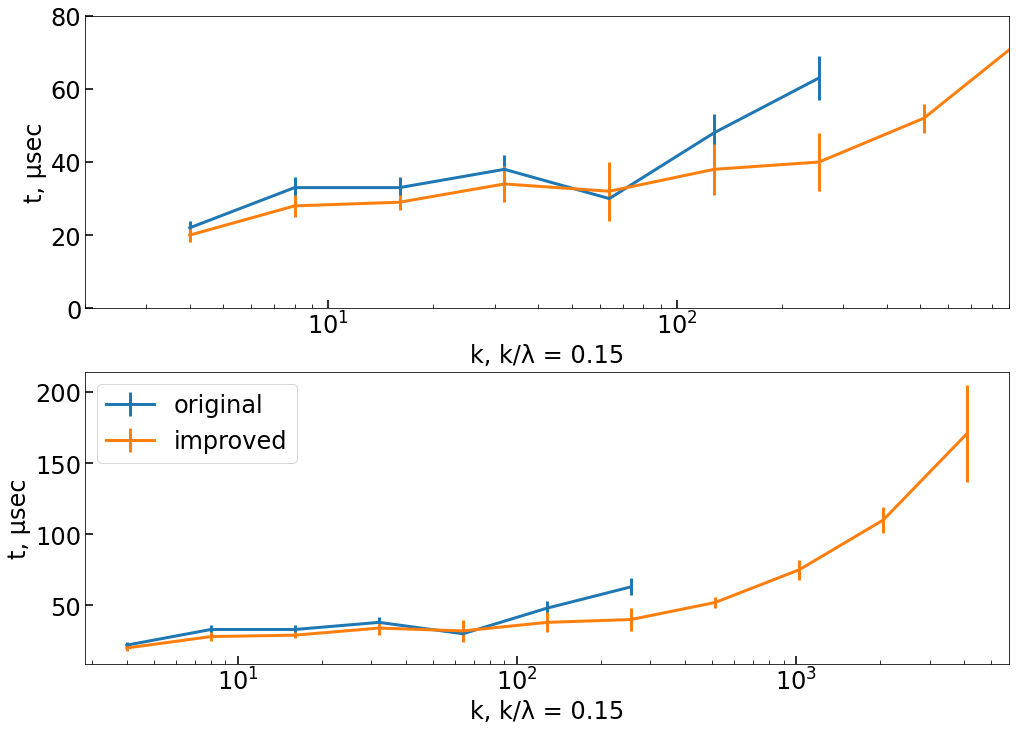

In [15]:
fig, ax = plt.subplots(nrows=2)
_scale = 0.15
threshold_test(ax, _scale, [4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096], NUM)
plt.legend()
ax[0].set_xlabel(f"k, k/λ = {_scale}");
ax[0].set_ylabel("t, μsec");
ax[0].set_xscale("log")
ax[0].set_xlim(2, 900)
ax[0].set_ylim(0, 80)
ax[1].set_xlabel(f"k, k/λ = {_scale}");
ax[1].set_ylabel("t, μsec");
ax[1].set_xscale("log")
fig.savefig("plots/boost_scale_fixed_0_15.png")

/home/vindex10/projects/.venvs/sandbox/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/vindex10/projects/.venvs/sandbox/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/vindex10/projects/.venvs/sandbox/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/vindex10/projects/.venvs/sandbox/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/vindex10/projects/.venvs/sandbox/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/vindex10/projects/.venvs/sandbox/l

,ν,λ,μsec_old,μsec_old_err,μsec_new,μsec_new_err,res_old,res_old_err,res_new,res_new_err
0,3.999990,80.000000,39.5,6.50,34.0,6.0,81.0063,0.0008,81.0063,0.0008
0,7.999993,160.000000,42.0,7.05,36.0,6.0,165.0150,0.0010,165.0150,0.0010
0,16.000004,320.000000,34.0,8.00,25.0,2.0,333.0200,0.0010,333.0200,0.0010
0,32.000007,640.000000,35.0,7.00,28.0,3.0,669.0220,0.0010,669.0220,0.0010
0,63.999983,1280.000000,44.0,8.05,41.0,8.0,1341.0200,0.0000,1341.0200,0.0000
0,128.000004,2559.999992,NaN,NaN,44.0,5.0,NaN,NaN,2685.0200,0.0000
0,255.999996,5120.000002,NaN,NaN,69.0,11.0,NaN,NaN,5373.0200,0.0000
0,512.000008,10240.000003,NaN,NaN,103.0,18.0,NaN,NaN,10749.0000,0.0000
0,1023.999991,20479.999994,NaN,NaN,153.0,21.0,NaN,NaN,21501.0000,0.0000
0,2047.999979,40959.999995,NaN,NaN,231.0,29.0,NaN,NaN,43005.0000,0.0000


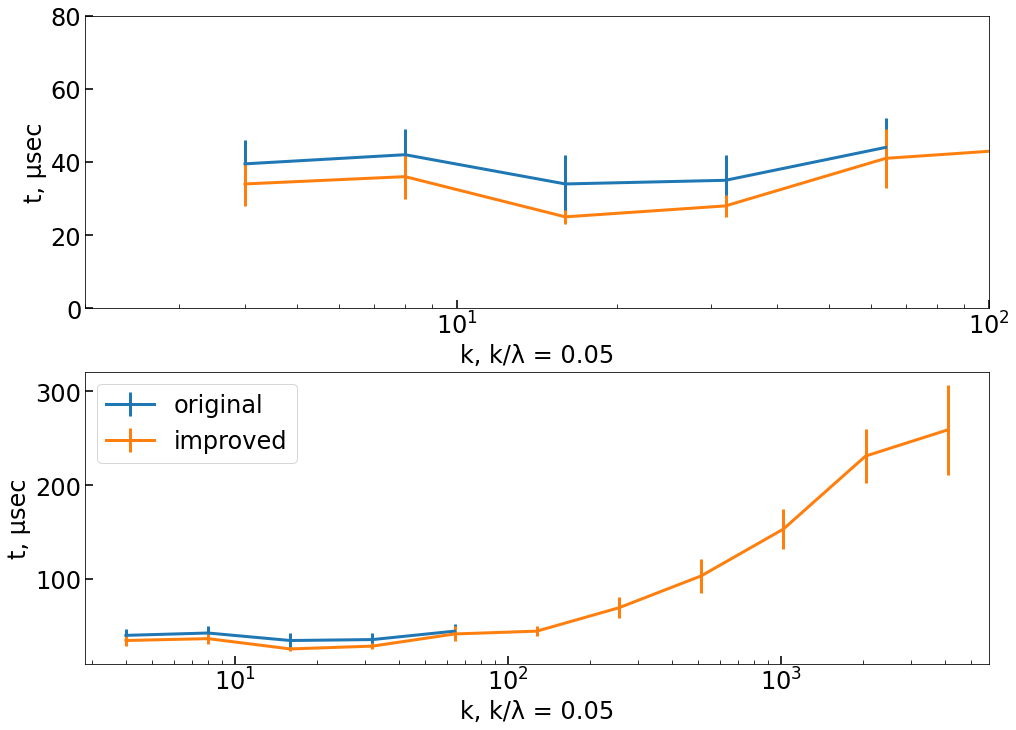

In [16]:
fig, ax = plt.subplots(nrows=2)
_scale = 0.05
threshold_test(ax, _scale, [4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096], NUM)
plt.legend()
ax[0].set_xlabel(f"k, k/λ = {_scale}");
ax[0].set_ylabel("t, μsec");
ax[0].set_xscale("log")
ax[0].set_xlim(2, 100)
ax[0].set_ylim(0, 80)
ax[1].set_xlabel(f"k, k/λ = {_scale}");
ax[1].set_ylabel("t, μsec");
ax[1].set_xscale("log")
fig.savefig("plots/boost_scale_fixed_0_05.png")

### Comments

* One can notice that original algorithm fails to find maximum at large values of $\lambda$, it is because the  major content of the PDF is located around $\lambda$ while at the guess point $x_0 = k + 1 << \lambda$ value of the PDF is 0 with high precision.

* In these tests we skipped $k = 2$ because boost's algorithm is built in the way that when maximum happens at 0 it takes a long time to approach it with division by two while stepping downwards. This can turn into another optimization of the initial guess $x_0$